In [1]:
from simulator import *
import matplotlib.pyplot as plt

Text(0, 0.5, 'transmitted flux')

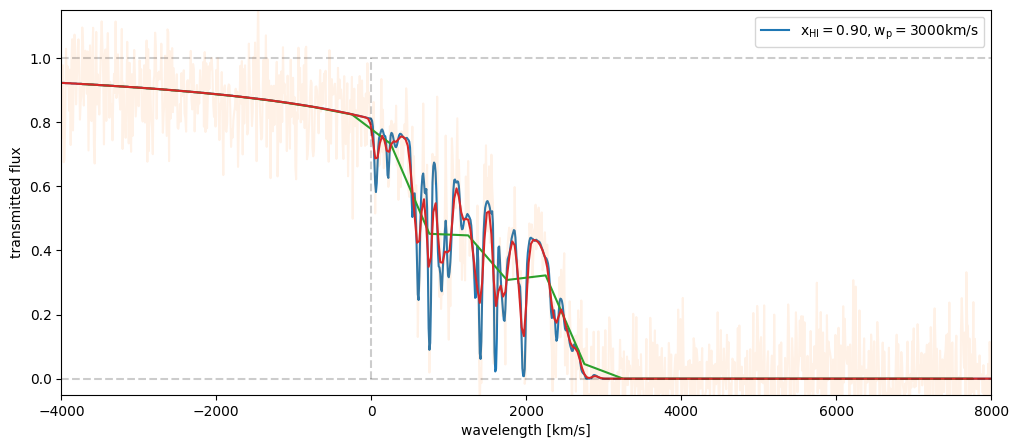

In [2]:
true_parameter=[0.9,3000]
simout=Simulator(true_parameter)
plt.figure(figsize=(12,5))
plt.plot(simout.raw_wv, simout.clean_spec,label=r"$\rm x_{{HI}}={:.2f}, w_p={:.0f} km/s$".format(true_parameter[0],true_parameter[1]))
plt.plot(simout.raw_wv, simout.noisy_spec,alpha=0.1)
plt.plot(simout.binning()[0],simout.binning()[1])
plt.plot(simout.gaussian_smoothing()[0],simout.gaussian_smoothing()[1])

plt.legend()
plt.hlines(0,-4000,8000,color='k',alpha=0.2,linestyle='--')
plt.hlines(1,-4000,8000,color='k',alpha=0.2,linestyle='--')
plt.vlines(0,0,1,color='k',alpha=0.2,linestyle='--')

plt.ylim(-0.05,1.15)
plt.xlim(-4001,8001)
plt.xlabel("wavelength [km/s]")
plt.ylabel("transmitted flux")

In [11]:
def train_simulator(param,dataset="train"):
    sim=Simulator(param, SNR=10)
    outwv, outspec=sim.binning(binsize=500)
    return outspec
def crosscheck_simulator(param,dataset="rest"):
    sim=Simulator(param, SNR=10)
    outwv, outspec=sim.binning(binsize=500)
    return outspec

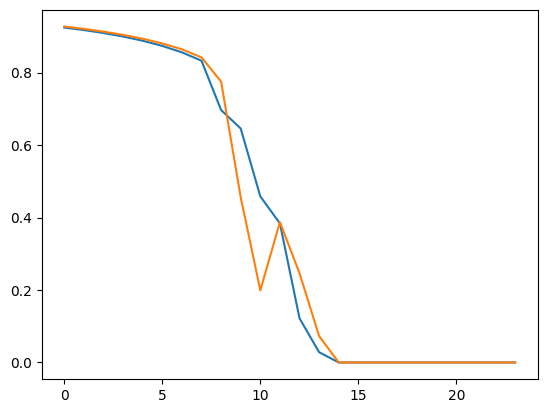

In [12]:
plt.plot(train_simulator(true_parameter))
plt.plot(crosscheck_simulator(true_parameter))

In [5]:
import torch
print(torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import sbi
from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

False


In [6]:
# set prior distribution for the parameters
num_dim = 2
prior = utils.BoxUniform(low=torch.tensor([0,0]), high=torch.tensor([1,8000]))
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(train_simulator, prior)


In [7]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=200000)


Running 200000 simulations.:   0%|          | 0/200000 [00:00<?, ?it/s]

In [10]:
torch.save(theta, 'training_theta_bin500kmps.t')
torch.save(x, 'training_x_bin500kmps.t')

In [13]:
num_sbc_runs = 1000 # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs=[]

for theta in thetas:
    xs.append(crosscheck_simulator(theta))
xs=torch.tensor(np.array(xs))


In [14]:
torch.save(thetas, 'calib_theta_bin500kmps.t')
torch.save(xs, 'calib_x_bin500kmps.t')

In [14]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf",  hidden_features=10, num_transforms=5,num_blocks=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [16]:
# # run the inference procedure on one round and 10000 simulated data points

# theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=200000)


In [17]:
# torch.save(theta, 'training_theta.t')
# torch.save(x, 'training_x.t')

In [20]:
theta[:1000]

tensor([[5.1996e-01, 5.6259e+03],
        [4.7865e-01, 7.0045e+03],
        [2.6221e-01, 2.2864e+03],
        ...,
        [6.4980e-01, 3.2509e+03],
        [8.2674e-01, 1.6305e+03],
        [9.6400e-01, 4.2940e+03]])

In [41]:
theta = torch.load('training_theta_sm50.t')[:10000]
x = torch.load('training_x_sm50.t')[:10000]

In [47]:
inference.append_simulations(theta, x)

In [48]:
t0=time.time()
density_estimator = inference.train()
t1=time.time()
print("time spent = {:.1f} min".format((t1-t0)/60.))

 Neural network successfully converged after 33 epochs.time spent = 0.9 min


In [44]:
posterior = inference.build_posterior(density_estimator)


In [31]:
inference

In [38]:
density_estimator??

In [ ]:
density_estimator.

In [39]:
samples = posterior.sample((10000,), x=torch.tensor(x_observed))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

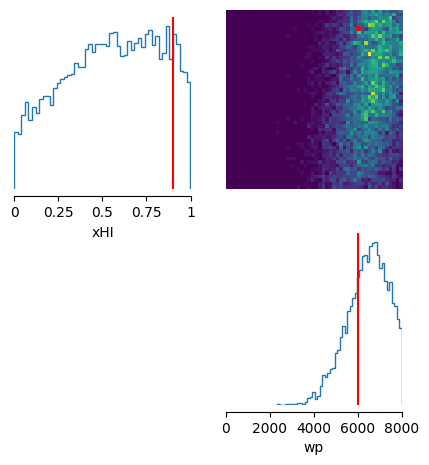

In [40]:
# create the figure
fig, ax = analysis.pairplot(
    samples.to("cpu"),
    points=true_parameter,
    labels=["xHI", r"wp"],
    limits=[[0, 1], [0, 8000]],
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(5, 5),
)

In [28]:
num_sbc_runs = 1000 # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs=[]

for theta in thetas:
    xs.append(crosscheck_simulator(theta))
xs=torch.tensor(np.array(xs))


num_posterior_samples = 1000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    933 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


In [30]:
# torch.save(thetas, 'calib_theta.t')
# torch.save(xs, 'calib_x.t')

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.06742465 0.28580517]


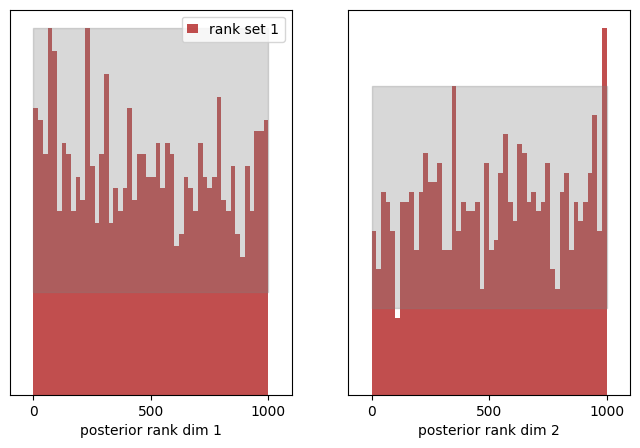

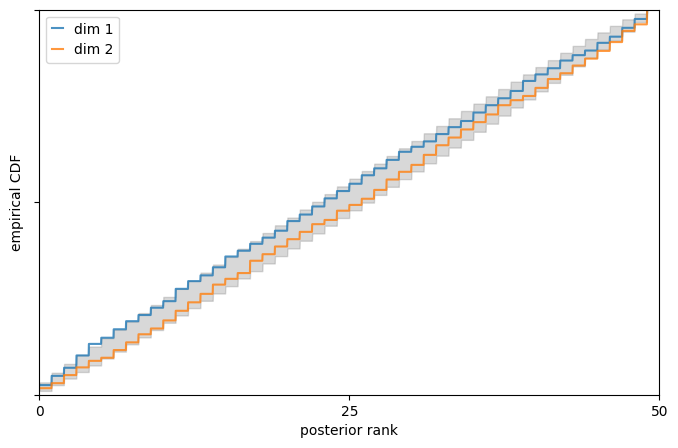

In [35]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)

from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)
f, ax = sbc_rank_plot(ranks, 1000, plot_type="cdf")

In [36]:
sbc_rank_plot??

### create a NN

In [ ]:
class SummaryNet(nn.Module):
    def __init__(self,n_hidden):
        self.n_hidden=n_hidden
        super().__init__()
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=1201, out_features=32)
        self.hidden=[]
        for i in range(self.n_hidden):
            self.hidden.append(nn.Linear(in_features=32, out_features=32))
        self.out = nn.Linear(in_features=32, out_features=2)

    def forward(self, x):
#         x = x.view(-1, 1, 32, 32)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = x.view(-1, 6 * 4 * 4)
        x = self.fc(x)
        for i in range(self.n_hidden):
            x=self.hidden[i](x)
        x=self.out(x)
        return x


embedding_net = SummaryNet(n_hidden=4)

In [31]:
# set prior distribution for the parameters
num_dim = 2
prior = utils.BoxUniform(low=torch.tensor([0,0]), high=torch.tensor([1,8000]))


# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)


In [33]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=nn.Identity(), hidden_features=20, num_transforms=10
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [34]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=50000)


Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

In [35]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)


 Neural network successfully converged after 23 epochs.

In [40]:
num_sbc_runs = 1000 # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs=[]

for theta in thetas:
    xs.append(crosscheck_simulator(theta))
xs=torch.tensor(np.array(xs))


num_posterior_samples = 1000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.06742465 0.28580517]


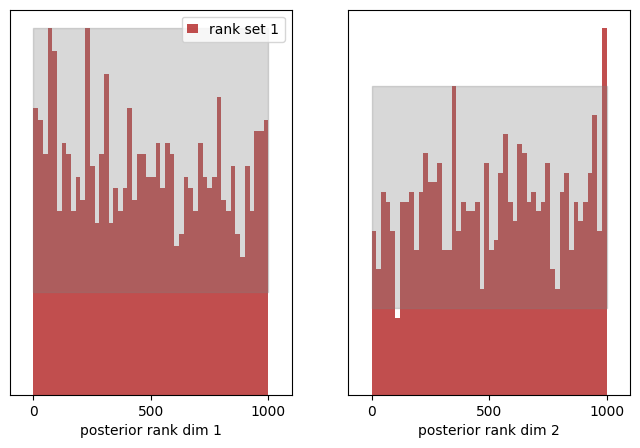

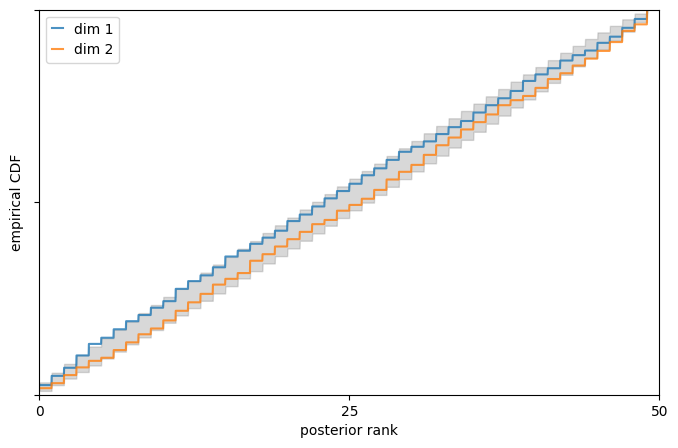

In [31]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)

from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

f.savefig("rank_hist.pdf")
f, ax = sbc_rank_plot(ranks, 5000, plot_type="cdf")

In [33]:
f.savefig("cdf.pdf")

### test

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

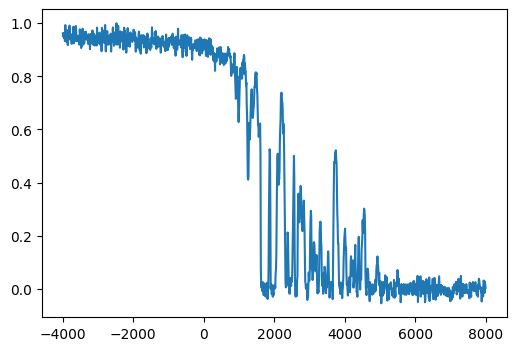

In [37]:
true_parameter = torch.tensor([0.90, 6000])

x_observed=my_simulator(true_parameter)
plt.figure(figsize=(6,4))
plt.plot(wv_flux_forest,x_observed)


samples = posterior.set_default_x(x_observed).sample((50000,))


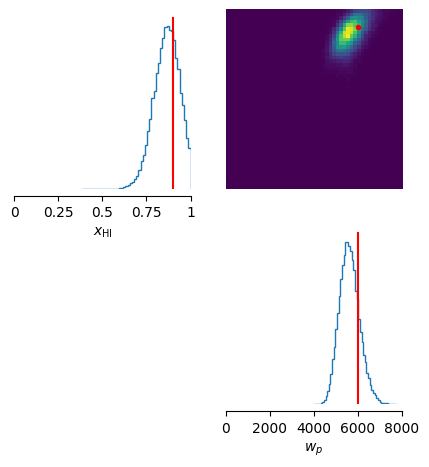

In [38]:
fig, ax = analysis.pairplot(
    samples[10000:],
    points=true_parameter,
    labels=[r"$x_{\rm HI}$", r"$w_p$"],
    limits=[[0, 1], [0,8000]],
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(5, 5),
)

In [39]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=18
plt.rcParams["xtick.labelsize"]=14
plt.rcParams["ytick.labelsize"]=14

In [144]:

plt.plot(wv_flux_LSS,observation_075_4000,label=r"$(\left< x_{\rm HI}\right>_V, p_w)=(0.75,6000 \rm [km/s])$",color="tab:blue")
plt.plot(wv_flux_LSS,observation_025_4000,label=r"$(\left< x_{\rm HI}\right>_V, p_w)=(0.25,6000 \rm [km/s])$",color="tab:orange")

plt.legend(fontsize=12)
plt.ylabel(r"$\rm transmitted \ flux$")
plt.xlabel(r"$v \rm [km/s]$")

In [42]:
data=h5py.File("../../simulated_P036+03/F_a01209_spec.hdf5",'r')
lrnL=list(data.keys())

In [74]:
datawing=h5py.File("../../simulated_P036+03/F_a01209_damping_wing_spec.hdf5",'r')
xT=h5py.File("../../simulated_P036+03/F_a01209.hdf5",'r')


In [68]:
datawing.get(lrnL[10*i+2]).keys()

<KeysViewHDF5 ['damping_wing_spec_xT_1e3yr', 'damping_wing_spec_xT_1e4yr', 'damping_wing_spec_xT_1e5yr', 'damping_wing_spec_xT_1e6yr', 'damping_wing_spec_xT_1e7yr', 'damping_wing_spec_xT_1e8yr', 'damping_wing_spec_xT_3e3yr', 'damping_wing_spec_xT_3e4yr', 'damping_wing_spec_xT_3e5yr', 'damping_wing_spec_xT_3e6yr', 'damping_wing_spec_xT_3e7yr', 'damping_wing_spec_xT_6e7yr']>

In [78]:
xT.get(lrnL[10*i+2]+"/xT_1e6yr")

<HDF5 dataset "xT_1e6yr": shape (1653, 5), type "<f8">

In [83]:
Hz=779.

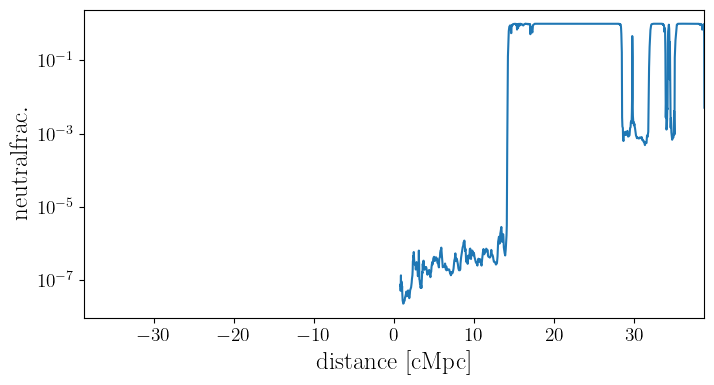

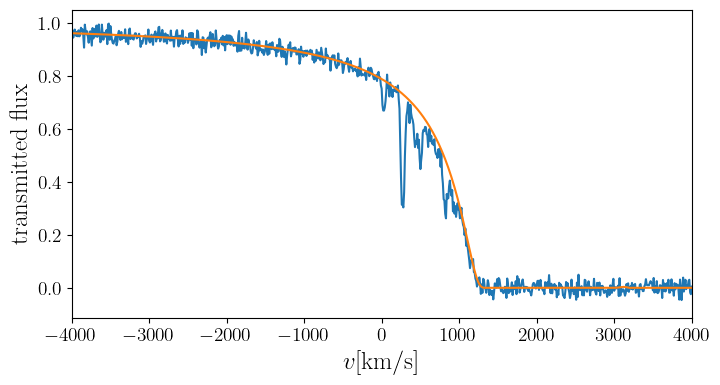

In [86]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=18
plt.rcParams["xtick.labelsize"]=14
plt.rcParams["ytick.labelsize"]=14
i=4
plt.figure(figsize=(8,4))
xHI=np.array(xT.get(lrnL[10*i+2]+"/xT_1e6yr"))
plt.plot(xHI[:,0]*(1+6.54),xHI[:,1])
plt.yscale("log")
plt.xlim(-4000/Hz*(1+6.54),4000/Hz*(1+6.54))
plt.xlabel(r"$\rm distance \ [cMpc]$")
plt.ylabel(r"$\rm neutral frac.$")
plt.show()

plt.figure(figsize=(8,4))
s=np.array(data.get(lrnL[10*i+2]+"/spec_xT_1e6yr"))
noise=np.random.normal(scale=0.02,size=1201)
snoise=s[::10][:1201]+noise
plt.plot(wv_flux_LSS,snoise)
sw=np.array(datawing.get(lrnL[10*i+2]+"/damping_wing_spec_xT_1e6yr"))
plt.plot(wv_flux_LSS,sw[::10][:1201])
plt.xlim(-4000,4000)
plt.ylabel(r"$\rm transmitted \ flux$")
plt.xlabel(r"$v \rm [km/s]$")
plt.show()

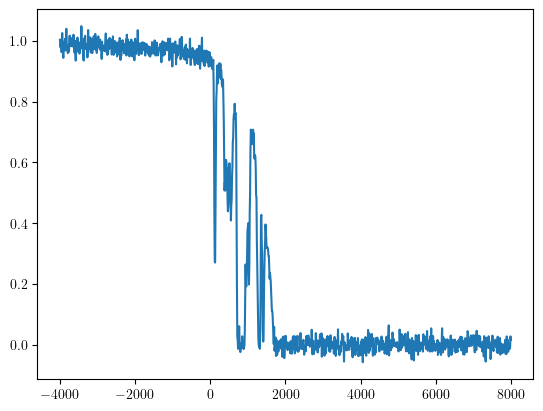

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

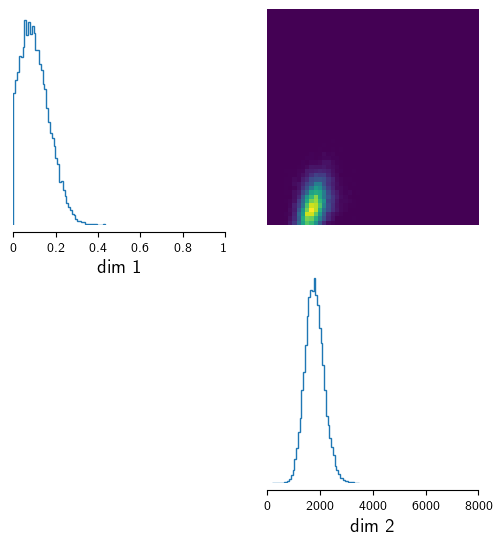

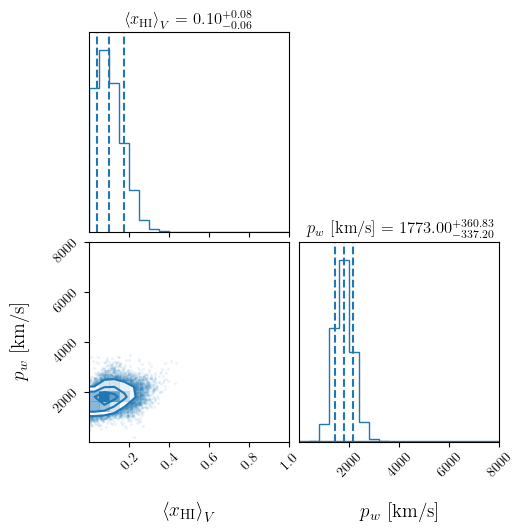

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

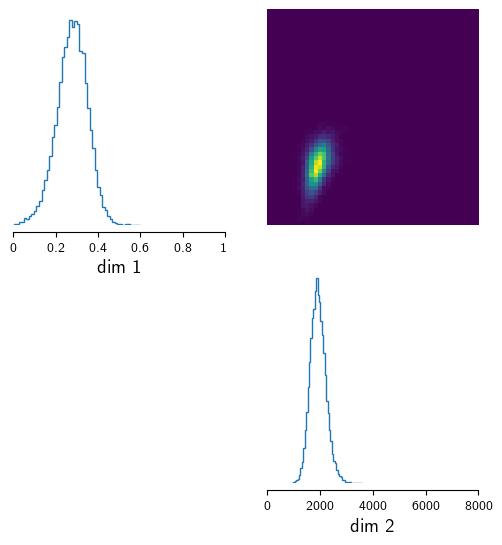

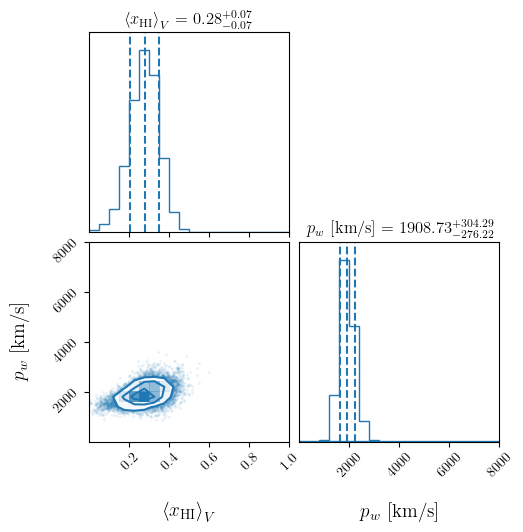

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

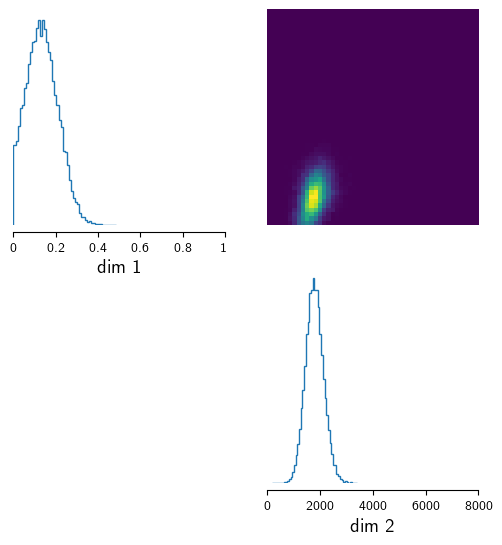

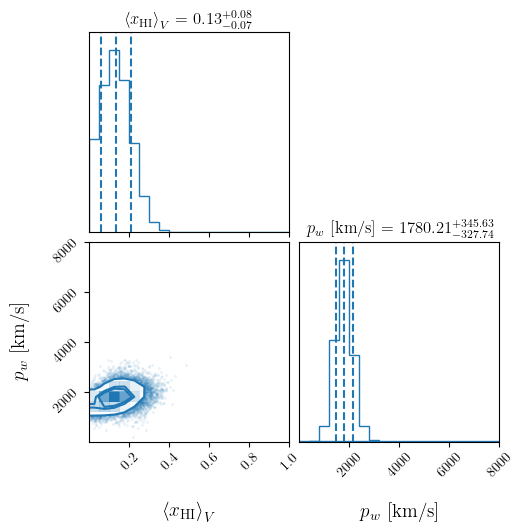

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

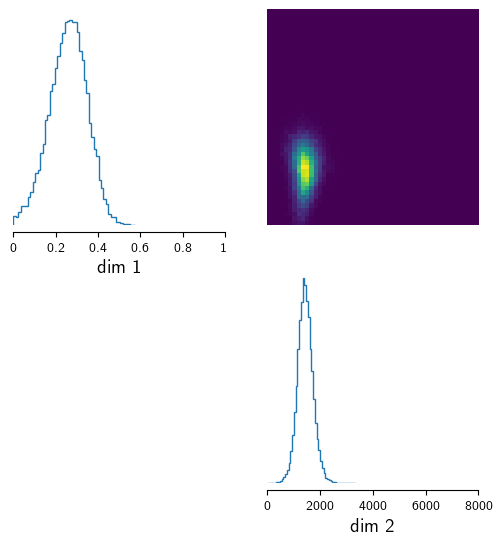

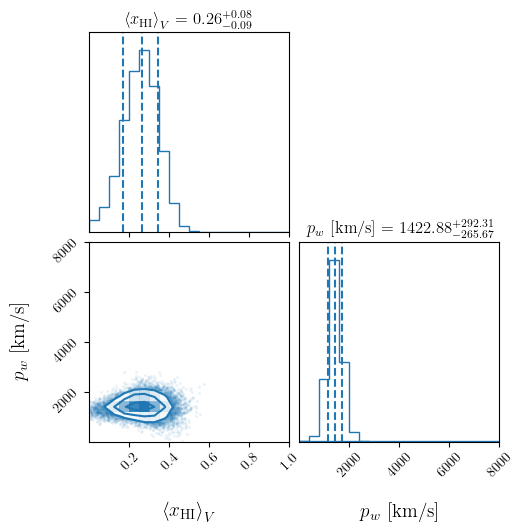

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

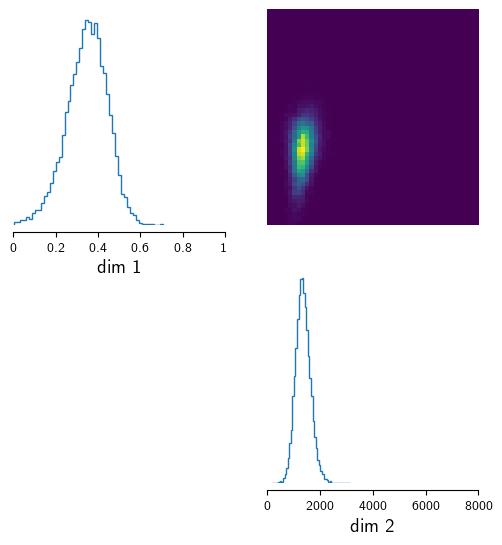

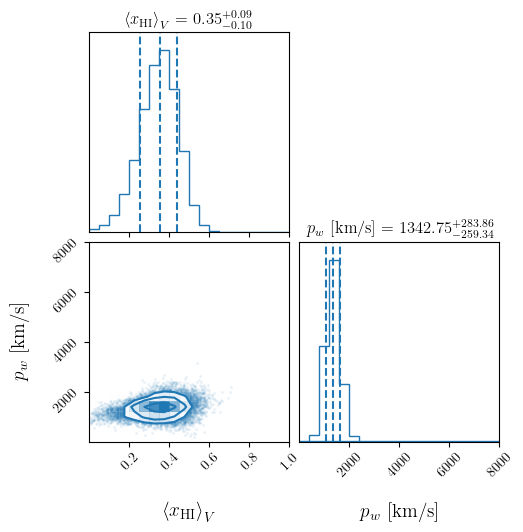

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

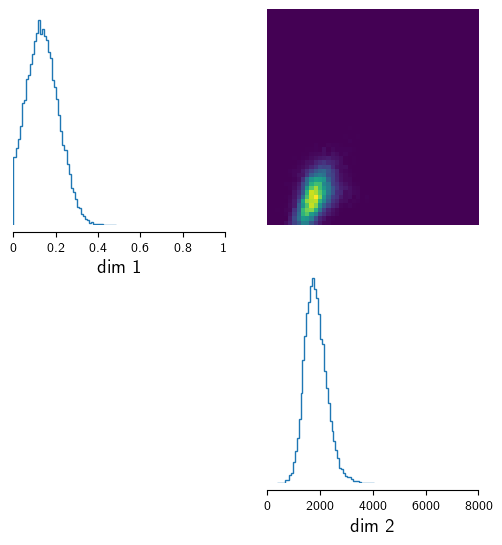

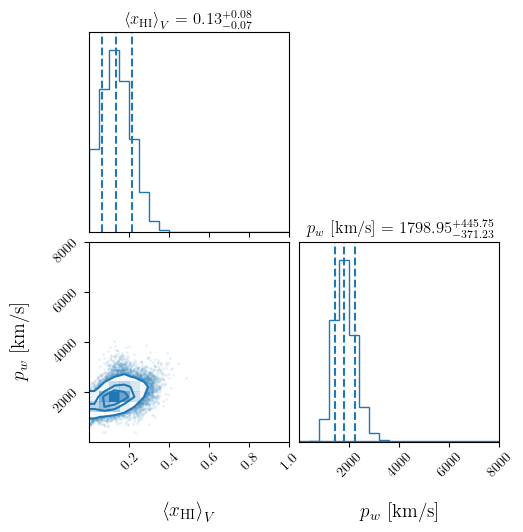

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

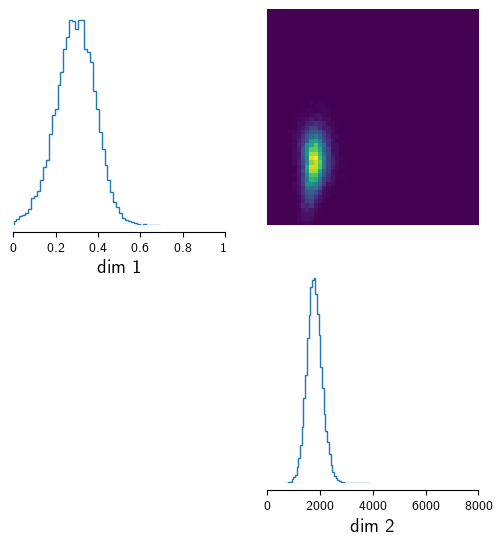

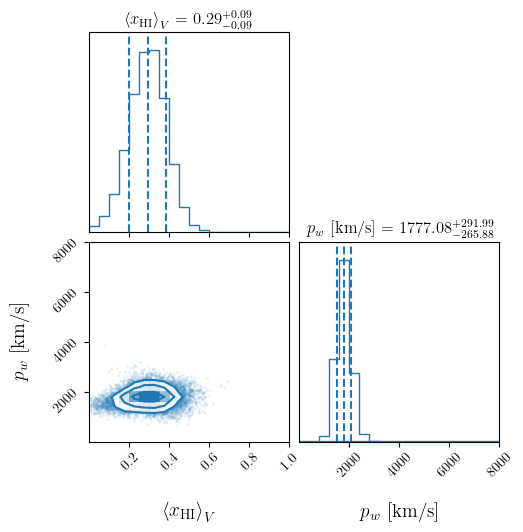

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

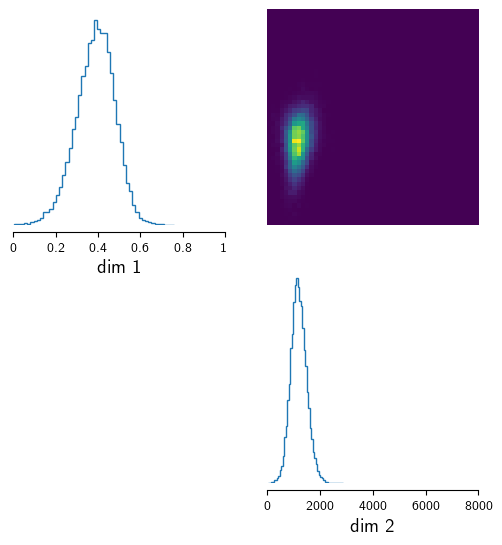

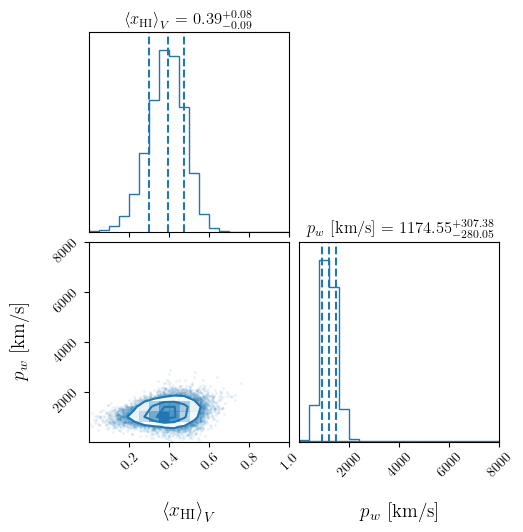

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

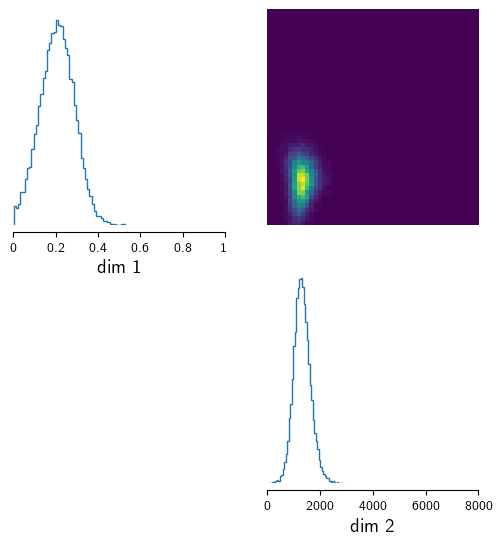

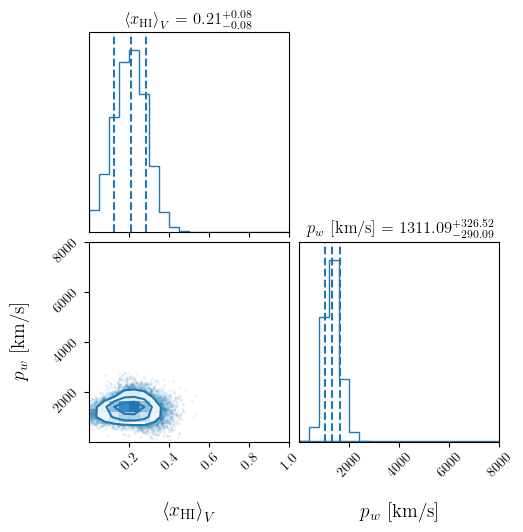

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

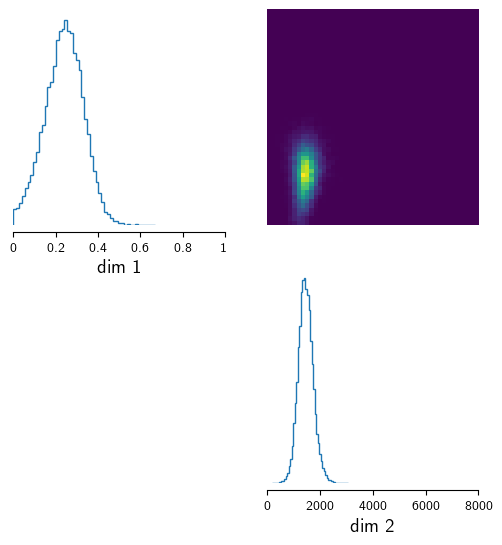

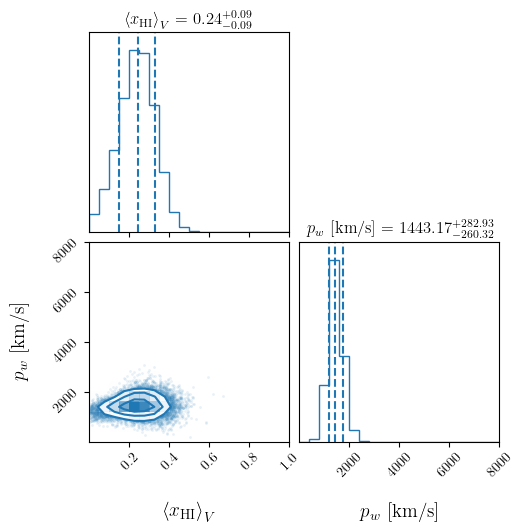

In [56]:
for i in range(10):
    s=np.array(data.get(lrnL[10*i+2]+"/spec_xT_1e6yr"))
    noise=np.random.normal(scale=0.02,size=1201)
    snoise=s[::10][:1201]+noise
    plt.plot(wv_flux_LSS,snoise)
    plt.show()
    samples = posterior.sample((20000,), x=snoise)
    log_probability = posterior.log_prob(samples, x=snoise)
    _ = analysis.pairplot(samples, limits=[[0,1],[0,8000]], figsize=(6,6))
    
    plt.rcParams["axes.labelsize"]=14
    plt.rcParams["xtick.labelsize"]=10
    plt.rcParams["ytick.labelsize"]=10

    figure = corner.corner(
        np.array(samples[2000:]),
        range=[(0.,1.), (0.,8000)],
        labels=[
            r"$\left< x_{\rm HI}\right>_V$",
            r"$p_w \rm \ [km/s]$",
            r"$\log \alpha$",
            r"$\Gamma \, [\mathrm{parsec}]$",
        ],
        quantiles=[0.16, 0.5, 0.84],
        color="tab:blue",
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

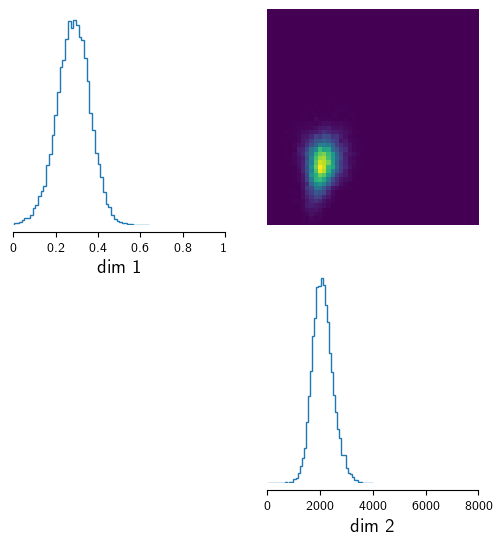

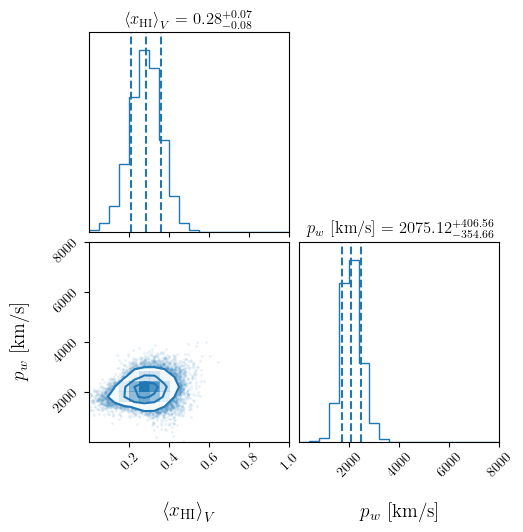

In [151]:
observation_075_4000=my_simulator(torch.tensor([0.75,6000]))
observation_025_4000=my_simulator(torch.tensor([0.25,6000]))

Text(0.5, 0, '$v \\rm [km/s]$')

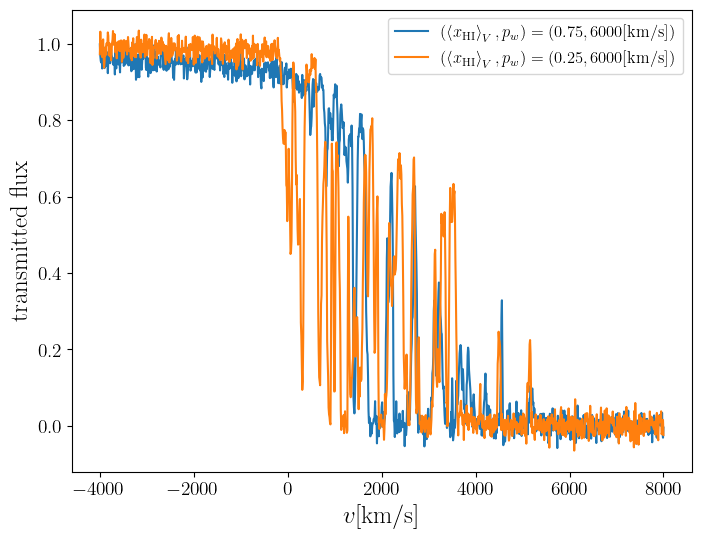

In [152]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=18
plt.rcParams["xtick.labelsize"]=14
plt.rcParams["ytick.labelsize"]=14
plt.figure(figsize=(8,6))
plt.plot(wv_flux_LSS,observation_075_4000,label=r"$(\left< x_{\rm HI}\right>_V, p_w)=(0.75,6000 \rm [km/s])$",color="tab:blue")
plt.plot(wv_flux_LSS,observation_025_4000,label=r"$(\left< x_{\rm HI}\right>_V, p_w)=(0.25,6000 \rm [km/s])$",color="tab:orange")

plt.legend(fontsize=12)
plt.ylabel(r"$\rm transmitted \ flux$")
plt.xlabel(r"$v \rm [km/s]$")

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

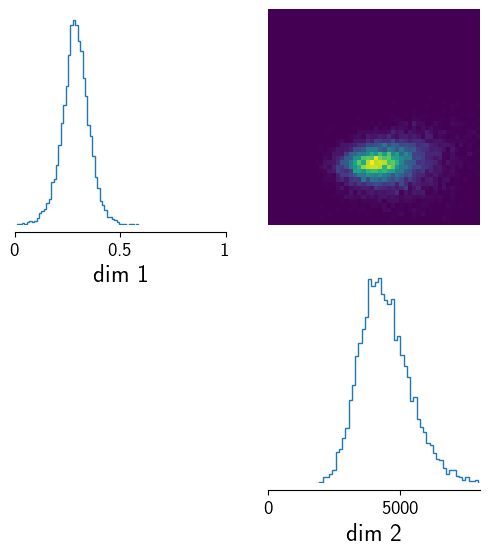

In [153]:
samples_025_4000 = posterior.sample((20000,), x=observation_025_4000)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[0,1],[0,8000]], figsize=(6,6))

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

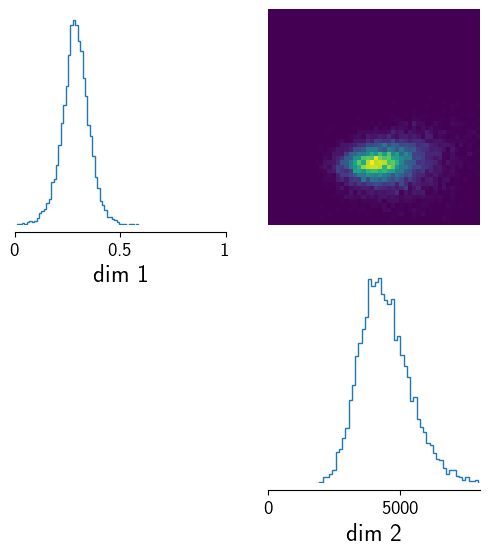

In [154]:
samples_075_4000 = posterior.sample((20000,), x=observation_075_4000)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[0,1],[0,8000]], figsize=(6,6))

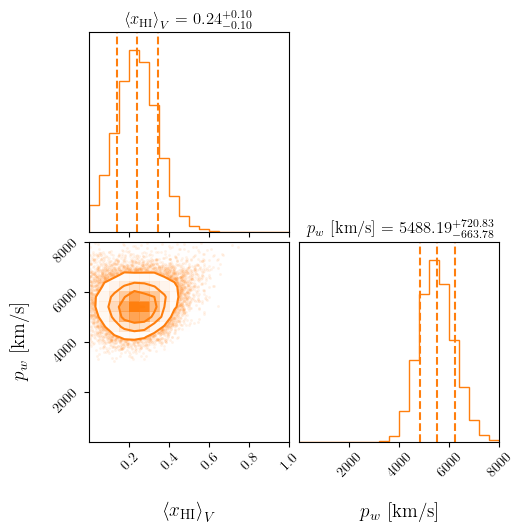

In [155]:
plt.rcParams["axes.labelsize"]=14
plt.rcParams["xtick.labelsize"]=10
plt.rcParams["ytick.labelsize"]=10

figure = corner.corner(
    np.array(samples_025_4000),
    range=[(0.,1.), (0.,8000)],
    labels=[
        r"$\left< x_{\rm HI}\right>_V$",
        r"$p_w \rm \ [km/s]$",
        r"$\log \alpha$",
        r"$\Gamma \, [\mathrm{parsec}]$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    color="tab:orange",
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


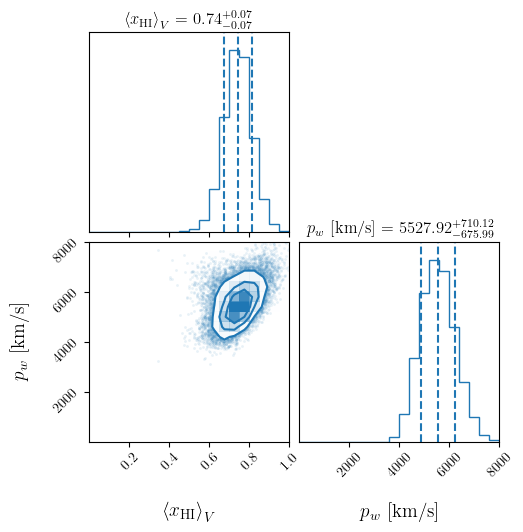

In [157]:
plt.rcParams["axes.labelsize"]=14
plt.rcParams["xtick.labelsize"]=10
plt.rcParams["ytick.labelsize"]=10

figure = corner.corner(
    np.array(samples_075_4000),
    range=[(0.,1.), (0.,8000)],
    labels=[
        r"$\left< x_{\rm HI}\right>_V$",
        r"$p_w \rm \ [km/s]$",
        r"$\log \alpha$",
        r"$\Gamma \, [\mathrm{parsec}]$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    color="tab:blue",
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


In [ ]:
for xHI in np.linspace(0,1,10):
    for wingP in np.linspace(0,8000,10):

        observation=my_simulator(torch.tensor([xHI,wingP]))
        plt.plot(wv_flux_LSS,observation)

        samples = posterior.sample((10000,), x=observation)
        log_probability = posterior.log_prob(samples, x=observation)
        _ = analysis.pairplot(samples, limits=[[0,1],[0,8000]], figsize=(6,6))
#         analysis.show()
        print("true xHI,wingP=",xHI,wingP)
        print(samples[:,0].median(),samples[:,0].median()-samples[:,0].std(),samples[:,0].median()+samples[:,0].std())
        print(samples[:,1].median(),samples[:,1].median()-samples[:,1].std(),samples[:,1].median()+samples[:,1].std())

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 0.0
tensor(0.1282) tensor(0.0605) tensor(0.1959)
tensor(689.4484) tensor(53.7378) tensor(1325.1589)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 888.8888888888889
tensor(0.0734) tensor(0.0135) tensor(0.1334)
tensor(959.6932) tensor(511.6646) tensor(1407.7219)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 1777.7777777777778
tensor(0.1128) tensor(0.0420) tensor(0.1835)
tensor(2534.4524) tensor(2037.8112) tensor(3031.0938)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 2666.666666666667
tensor(0.0932) tensor(0.0269) tensor(0.1595)
tensor(2020.3495) tensor(1578.6873) tensor(2462.0117)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 3555.5555555555557
tensor(0.0788) tensor(0.0147) tensor(0.1428)
tensor(3474.1006) tensor(2862.7759) tensor(4085.4253)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 4444.444444444444
tensor(0.1008) tensor(0.0265) tensor(0.1751)
tensor(7144.5840) tensor(6348.8486) tensor(7940.3193)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 5333.333333333334
tensor(0.0614) tensor(0.0065) tensor(0.1162)
tensor(4691.0400) tensor(4027.0933) tensor(5354.9868)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 6222.222222222223
tensor(0.1268) tensor(0.0432) tensor(0.2104)
tensor(6602.0552) tensor(5744.7705) tensor(7459.3398)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 7111.111111111111
tensor(0.1519) tensor(0.0718) tensor(0.2321)
tensor(6076.9126) tensor(5098.6479) tensor(7055.1772)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.0 8000.0
tensor(0.0845) tensor(0.0174) tensor(0.1516)
tensor(7090.0898) tensor(6178.2837) tensor(8001.8960)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.1111111111111111 0.0
tensor(0.1653) tensor(0.0745) tensor(0.2561)
tensor(641.8454) tensor(218.2853) tensor(1065.4055)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.1111111111111111 888.8888888888889
tensor(0.0855) tensor(0.0254) tensor(0.1456)
tensor(977.6548) tensor(499.7150) tensor(1455.5946)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.1111111111111111 1777.7777777777778
tensor(0.0858) tensor(0.0220) tensor(0.1495)
tensor(1453.4192) tensor(937.9310) tensor(1968.9073)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.1111111111111111 2666.666666666667
tensor(0.1666) tensor(0.0938) tensor(0.2395)
tensor(2705.5125) tensor(2236.8528) tensor(3174.1721)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.1111111111111111 3555.5555555555557
tensor(0.2146) tensor(0.1348) tensor(0.2944)
tensor(3406.8770) tensor(2841.5400) tensor(3972.2139)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.1111111111111111 4444.444444444444
tensor(0.1399) tensor(0.0619) tensor(0.2180)
tensor(5049.8047) tensor(4269.2837) tensor(5830.3257)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

true xHI,wingP= 0.1111111111111111 5333.333333333334
tensor(0.1473) tensor(0.0589) tensor(0.2356)
tensor(6345.8140) tensor(5545.7104) tensor(7145.9175)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
posterior = infer(my_simulator, prior, method="SNLE", num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [54]:
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[0,1],[0,8000]], figsize=(6,6))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
posterior = infer(my_simulator, prior, method="SNPE", num_simulations=1000)


In [12]:
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[0,1],[0,8000]], figsize=(6,6))

NameError: name 'posterior' is not defined

In [20]:
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[0,1],[0,8000]], figsize=(6,6))

NameError: name 'posterior' is not defined

In [ ]:


num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))


def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

posterior = infer(simulator, prior, method="SNPE", num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
observation = torch.zeros(3)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

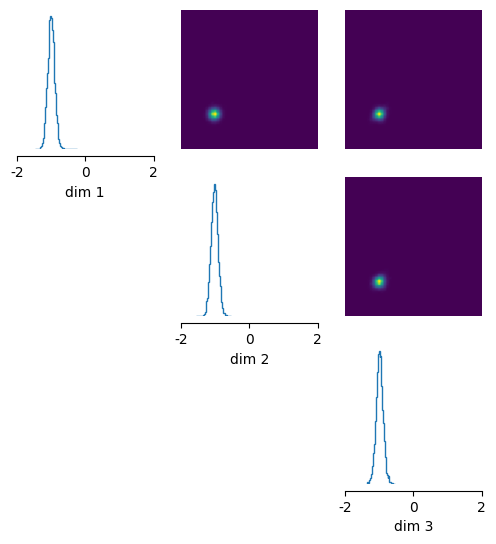

In [10]:
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6))

In [ ]:
observation = torch.zeros(3)
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6))


In [2]:
from sbi.examples.minimal import simple
posterior = simple()
print(posterior)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 44 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.
